In [0]:
# Read dataset

import pandas as pd
df=pd.read_csv("/content/drive/My Drive/ead_sentiment.csv",encoding="ISO-8859-1",names=['target','ids','date','flag','user','text'])

In [0]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df.shape

(1600000, 6)

In [0]:
# Mapping labels to respective sentiments

decode_map={0:"NEGATIVE",2:"NEUTRAL",4:"POSITIVE"}
def decode_sentiment(label):
  return decode_map[int(label)]

In [0]:
df.target=df.target.apply(lambda x : decode_sentiment(x))

In [0]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Labels distribution in dataset')

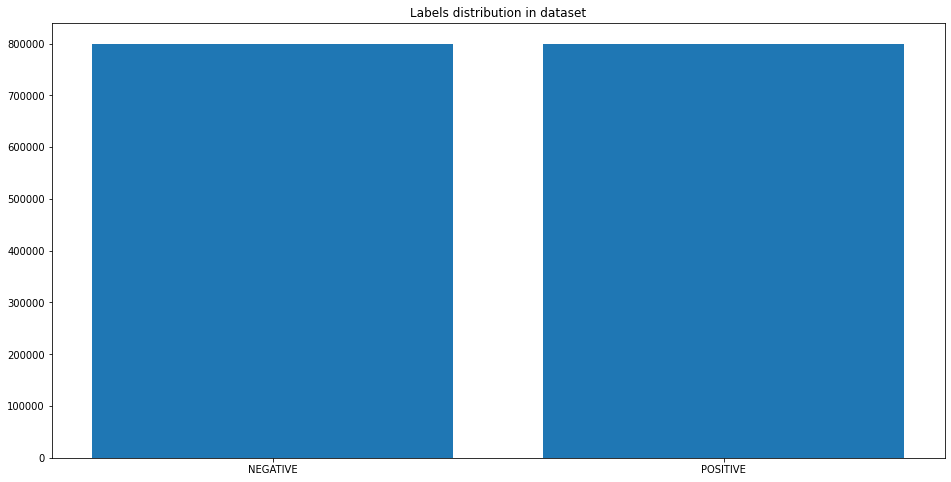

In [0]:
# checking for imbalance in dataset

from collections import Counter
target_cnt=Counter(df.target)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(),target_cnt.values())
plt.title("Labels distribution in dataset")

In [0]:
# Data pre-processing

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words("english")

from nltk.stem import SnowballStemmer
stemmer=SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Removing stopwords,@,htpps etc(Text cleaning)
# Doing stemming(Converting to base form)
import re

def preprocess(text,stem=False):
  text=re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ',str(text).lower()).strip()
  tokens=[]
  for token in text.split():
    if stem:
      tokens.append(stemmer.stem(token))
    else:
      tokens.append(token)
  return " ".join(tokens)


In [0]:
df.text=df.text.apply(lambda x : preprocess(x))

In [0]:
# Train-Test-Split
from sklearn.model_selection import train_test_split

df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)
print(df_train.shape,df_test.shape)

(1280000, 6) (320000, 6)


In [0]:
# Converting each sentence into list of words
documents=[_text.split() for _text in df_train.text]

In [0]:
import multiprocessing
multiprocessing.cpu_count()

4

In [0]:
# Using Word2Vec model

import gensim
w2v_model=gensim.models.word2vec.Word2Vec(size=300,window=7,min_count=10,workers=8)

In [0]:
w2v_model.build_vocab(documents)

In [0]:
words=w2v_model.wv.vocab.keys()
vocab_size=len(words)
print(vocab_size)

30520


In [0]:
words

dict_keys(['with', 'ya', 'quot', 'i', 'd', 'like', 'a', 'palm', 'pre', 'charger', 'yes', 'that', 'sounds', 'good', 'but', 'is', 'my', 'beer', 'ready', 'now', 'prelaunch', 'felt', 'the', 'earthquake', 'this', 'afternoon', 'it', 'seems', 'to', 'be', 'at', 'on', 'shirts', 'are', 'so', 'in', 'me', 'likey', 'pretty', 'bad', 'night', 'into', 'crappy', 'morning', 'fml', 'if', 'only', 'didnt', 'say', 'he', 'could', 'go', 'work', 'today', 'yeah', 'what', 'clear', 'view', 'one', 'more', 'time', 'follow', 'fam', 'ff', 'elle', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'will', 'added', 'next', 'tm', 'video', 'please', 'met', 'your', 'fiancee', 'ian', 's', 'party', 'other', 'day', 'btw', 'she', 'very', 'sweet', 'congrats', 'you', 'guys', 'gawd', 'they', 've', 'finished', 'whole', 'bowl', 'before', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'll', 'finish', 'and', 'craving', 'for', 'god', 'of', 'war', 'action', 'happy', 'mothers', 'all', 'grown', 'n', 'a

In [0]:
w2v_model.train(documents,total_examples=len(documents),epochs=32)

(406716743, 540038688)

In [0]:
# Cosine Similarity

w2v_model.most_similar('love')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('adore', 0.6581119298934937),
 ('luv', 0.6552386283874512),
 ('looove', 0.6251072883605957),
 ('loveee', 0.6116243600845337),
 ('loves', 0.6024850606918335),
 ('loooove', 0.5920731425285339),
 ('loved', 0.5906791687011719),
 ('miss', 0.5850239992141724),
 ('lovee', 0.5695315599441528),
 ('loove', 0.5245245099067688)]

In [0]:
# Text Tokenization

from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train.text)

# Leave 0 for padding
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

Using TensorFlow backend.


290572


In [0]:
# Doing padding

from keras_preprocessing.sequence import pad_sequences
x_train=pad_sequences(tokenizer.texts_to_sequences(df_train.text),maxlen=300)
x_test=pad_sequences(tokenizer.texts_to_sequences(df_test.text),maxlen=300)

In [0]:
print(x_train.shape,x_test.shape)

(1280000, 300) (320000, 300)


In [0]:
# Label Encoding

labels=df_train.target.unique().tolist()
labels.append('NEUTRAL')
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train=encoder.transform(df_train.target.tolist())
y_test=encoder.transform(df_test.target.tolist())

y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(y_train.shape,y_test.shape)

(1280000, 1) (320000, 1)


In [0]:
y_train,y_test

(array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]), array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [0]]))

In [0]:
# Building the embedding layer
import numpy as np

embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i]=w2v_model.wv[word]
print(embedding_matrix.shape)

(290572, 300)


In [0]:
from keras.layers import Embedding
embedding_layer=Embedding(vocab_size,300,weights=[embedding_matrix],input_length=300,trainable=False)

In [0]:
# Build LSTM model

from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM

model=Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87171600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,332,101
Trainable params: 160,501
Non-trainable params: 87,171,600
_________________________________________________________________


In [0]:
# Compile Model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
# Define callbacks for improved performance

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
callbacks=[ReduceLROnPlateau(monitor='val_loss',patience=5,cooldown=0),
EarlyStopping(monitor='val_acc',min_delta=1e-4,patience=5)]

In [0]:
# Train Model

history=model.fit(x_train,y_train,batch_size=1024,epochs=32,validation_split=0.1,verbose=1,callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/32
1152000/1152000 [==============================] - 5087s 4ms/step - loss: 0.4929 - accuracy: 0.7595 - val_loss: 0.4238 - val_accuracy: 0.8057
Epoch 2/32


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 5085s 4ms/step - loss: 0.4465 - accuracy: 0.7900 - val_loss: 0.4090 - val_accuracy: 0.8135
Epoch 3/32
   2048/1152000 [..............................] - ETA: 1:21:56 - loss: 0.4435 - accuracy: 0.7920

KeyboardInterrupt: ignored

In [0]:
# Model Evaluation

score=model.evaluate(x_test,y_test,batch_size=1024)
print(score)

320000/320000 [==============================] - 466s 1ms/step
[0.4091035591125488, 0.8127750158309937]


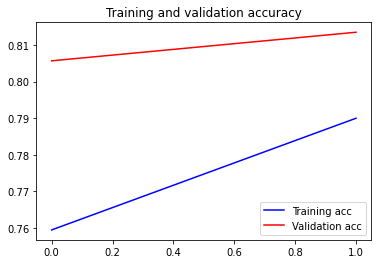

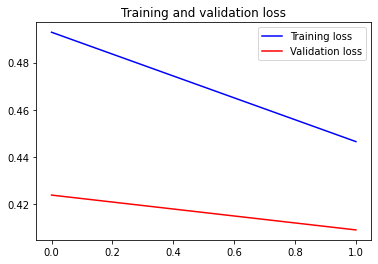

In [0]:
# Visualising the loss,acuuracy 

acc=model.history.history['accuracy']
val_acc=model.history.history['val_accuracy']
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Predict sentiment

def decode_sentiment(score,include_neutral=True):
  if include_neutral:
    label='NEUTRAL'
    if score<=0.4:
      label='NEGATIVE'
    elif score>=0.7:
      label='POSITIVE'

    return label
    
  else:
    return 'NEGATIVE' if score<0.5 else 'POSITIVE'

In [0]:
import time

def predict(text,include_neutral=True):
  start=time.time()
  
  # Text Tokenization
  x_test=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=300)
  
  # Predict
  score=model.predict([x_test])[0]
  
  # Decode sentiment
  label=decode_sentiment(score,include_neutral=include_neutral)

  end=time.time()

  return {"label":label,"score":float(score),"elapsed time":end-start}

In [0]:
predict("MPs vote to reject 12 December election plan - but Boris Johnson is likely to try again for a pre-Christmas poll")

{'elapsed time': 0.1758110523223877,
 'label': 'NEUTRAL',
 'score': 0.6725306510925293}

In [0]:
predict('He was a sick and depraved man, and now he’s gone. Baghdadi was vicious and violent and he died in a vicious and violent way. US President Donald Trump says the “world is now a much safer place” after the killing of IS leader Abu Bakr al-Baghdadi')

{'elapsed time': 0.0314936637878418,
 'label': 'NEGATIVE',
 'score': 0.08896996825933456}

In [0]:
predict("IS leader Abu Bakr al-Baghdadi was killed in US operation in Syria, President Donald Trump confirms")

{'elapsed time': 0.029137134552001953,
 'label': 'NEGATIVE',
 'score': 0.23288941383361816}

In [0]:
predict('I bought this property for $1.5 million: Condo resident yells profanities at security guards over visitor parking')

{'elapsed time': 0.030758142471313477,
 'label': 'NEUTRAL',
 'score': 0.44604578614234924}

In [0]:
# Building the confusion Matrix

y_pred_1d=[]
y_test_1d=list(df_test.target)

scores=model.predict(x_test,verbose=1,batch_size=1024)
y_pred_1d=[decode_sentiment(score,include_neutral=False) for score in scores]

320000/320000 [==============================] - 481s 2ms/step


In [0]:
def plot_confusion_matrix(cm,classes,title="Confusion matrix",cmap=plt.cm.Blues):

  cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title,fontsize=30)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=90,fontsize=22)
  plt.yticks(tick_marks,classes,fontsize=22)

  fmt='.2f'
  thresh=cm.max()/2
  import itertools

  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j]>thresh else 'black')
    
    plt.ylabel('True Label',fontsize=25)
    plt.xlabel('Predicted Label',fontsize=25)

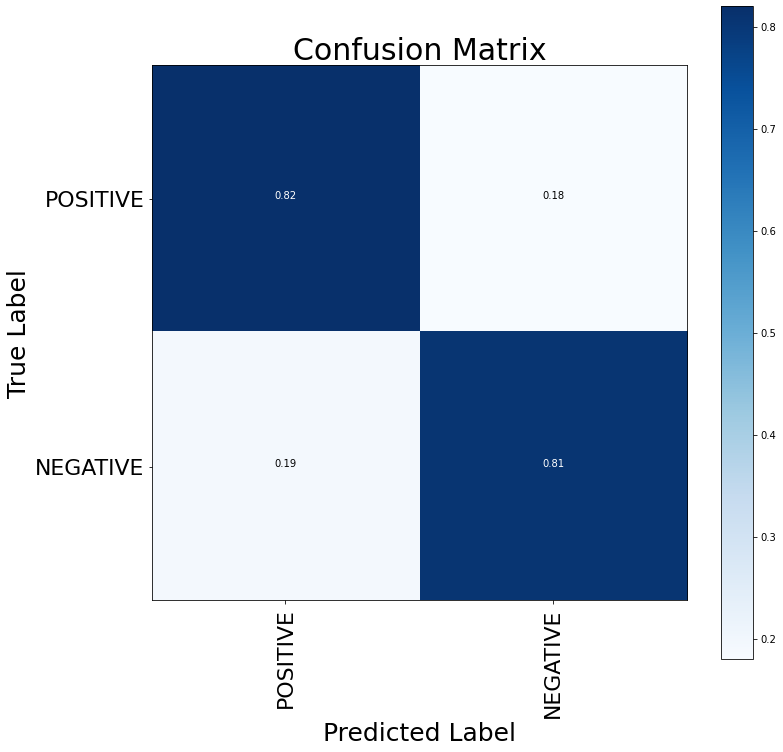

In [0]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

cnf_matrix=confusion_matrix(y_test_1d,y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix,classes=df_train.target.unique(),title="Confusion Matrix")
plt.show()

In [0]:
# Printing Classification Report

print(classification_report(y_test_1d,y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.82      0.81    159494
    POSITIVE       0.82      0.81      0.81    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [0]:
# Printing accuracy score

print(accuracy_score(y_test_1d,y_pred_1d))

0.812775


In [0]:
# Save Model weights
import pickle

model.save("model.h5")
w2v_model.save("model.w2v")
pickle.dump(tokenizer,open("tokenizer.pkl","wb"),protocol=0)
pickle.dump(encoder,open("encoder.pkl","wb"),protocol=0)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/model.h5')

Using TensorFlow backend.


In [0]:
import pickle
with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
# Predict sentiment

def decode_sentiment1(score,include_neutral=True):
  if include_neutral:
    label='NEUTRAL'
    if score<=0.4:
      label='NEGATIVE'
    elif score>=0.7:
      label='POSITIVE'

    return label
    
  else:
    return 'NEGATIVE' if score<0.5 else 'POSITIVE'

In [0]:
import time
from keras_preprocessing.sequence import pad_sequences

def predict1(text,include_neutral=True):
  start=time.time()
  
  # Text Tokenization
  x_test=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=300)
  
  # Predict
  score=model.predict([x_test])[0]
  
  # Decode sentiment
  label=decode_sentiment1(score,include_neutral=include_neutral)

  end=time.time()

  return {"label":label,"score":float(score),"elapsed time":end-start}

In [0]:
import pandas as pd
df_opp=pd.read_csv("/content/drive/My Drive/OPPOSITION.csv",error_bad_lines=False)

b'Skipping line 4: expected 4 fields, saw 5\nSkipping line 55: expected 4 fields, saw 5\nSkipping line 94: expected 4 fields, saw 5\nSkipping line 165: expected 4 fields, saw 5\nSkipping line 221: expected 4 fields, saw 5\nSkipping line 341: expected 4 fields, saw 5\nSkipping line 401: expected 4 fields, saw 5\nSkipping line 444: expected 4 fields, saw 5\nSkipping line 1064: expected 4 fields, saw 5\nSkipping line 1239: expected 4 fields, saw 5\nSkipping line 1241: expected 4 fields, saw 5\nSkipping line 1266: expected 4 fields, saw 5\nSkipping line 1402: expected 4 fields, saw 5\nSkipping line 1419: expected 4 fields, saw 5\nSkipping line 1578: expected 4 fields, saw 5\nSkipping line 1619: expected 4 fields, saw 5\nSkipping line 1620: expected 4 fields, saw 5\nSkipping line 1793: expected 4 fields, saw 5\nSkipping line 1848: expected 4 fields, saw 6\nSkipping line 1871: expected 4 fields, saw 5\nSkipping line 2447: expected 4 fields, saw 5\nSkipping line 2453: expected 4 fields, saw 5

In [0]:
df_gov=pd.read_csv("/content/drive/My Drive/Government.csv",error_bad_lines=False)

b'Skipping line 551: expected 4 fields, saw 5\nSkipping line 575: expected 4 fields, saw 5\nSkipping line 691: expected 4 fields, saw 5\nSkipping line 694: expected 4 fields, saw 5\nSkipping line 732: expected 4 fields, saw 5\nSkipping line 734: expected 4 fields, saw 8\nSkipping line 751: expected 4 fields, saw 8\nSkipping line 869: expected 4 fields, saw 5\nSkipping line 903: expected 4 fields, saw 5\nSkipping line 945: expected 4 fields, saw 5\nSkipping line 950: expected 4 fields, saw 5\nSkipping line 990: expected 4 fields, saw 5\nSkipping line 1014: expected 4 fields, saw 5\nSkipping line 1034: expected 4 fields, saw 5\nSkipping line 1047: expected 4 fields, saw 8\nSkipping line 1081: expected 4 fields, saw 8\nSkipping line 1088: expected 4 fields, saw 5\nSkipping line 1097: expected 4 fields, saw 5\nSkipping line 1118: expected 4 fields, saw 5\nSkipping line 1266: expected 4 fields, saw 8\nSkipping line 1294: expected 4 fields, saw 5\nSkipping line 1427: expected 4 fields, saw 5

In [0]:
# Reading tweet of opp.
df_opp["tweet"][2]

'RT @AOC: Congress gave a $4 TRILLION check to Wall Street while sending mom+pops on a wild goose chase for PPP.\n\nThat is major, oligarchic,…'

In [0]:
df_opp.head(5)

,ID,username,created_at,tweet
0,1,guitarguy_Al,2020-04-28 13:53:38,RT @VisurantViz: We are not your wage slaves. ...
1,2,MBennetfan,2020-04-28 13:53:38,RT @Independent: Pay people $50 a day to self-...
2,4,MasonTMatchak,2020-04-28 13:53:38,RT @AOC: Congress gave a $4 TRILLION check to ...
3,5,KathleenJaege13,2020-04-28 13:53:38,@tiger_o_matic Use first class stamps to mail ...
4,6,Xagent0024,2020-04-28 13:53:38,RT @katieporteroc: As the first single mom of ...


In [0]:
df_gov.head(5)

,ID,username,created_at,tweet
0,788,kashifashamsi,2020-04-30 05:41:58,RT @Fatima_Z0hra: You know the thing is right ...
1,789,mailtomahima,2020-04-30 05:41:58,RT @davidfrawleyved: Yogi Adityanath’s promise...
2,790,ParvezA02268277,2020-04-30 05:41:59,RT @AkyolinEnglish: The anti-Muslim madness in...
3,791,shrichandrajosh,2020-04-30 05:41:59,RT @themojo_in: BJP MLA Brij Bhushan Sharan se...
4,792,rizvansays,2020-04-30 05:41:59,RT @suhasinih: Bigotry of this order is what h...


In [0]:
opp_samples=df_opp.shape[0]
opp_samples

38727

In [0]:
gov_samples=df_gov.shape[0]
gov_samples

38474

In [0]:
# Sample text
df_gov["tweet"][0]

'RT @Fatima_Z0hra: You know the thing is right now what I am feeling,when I go out with my father &amp; mother,father wears kurta pyjama, with b…'

In [0]:
# Cong Data pre-processing

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words("english")

from nltk.stem import SnowballStemmer
stemmer=SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Removing stopwords,@,htpps etc(Text cleaning)
# Doing stemming(Converting to base form)
import re

def preprocess1(text,stem=False):
  text=re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ',str(text).lower()).strip()
  tokens=[]
  for token in text.split():
    if stem:
      tokens.append(stemmer.stem(token))
    else:
      tokens.append(token)
  return " ".join(tokens)


In [0]:
df_opp.tweet=df_opp.tweet.apply(lambda x : preprocess1(x))

In [0]:
df_gov.tweet=df_gov.tweet.apply(lambda x : preprocess1(x))

In [0]:
pred_opp=[]
for i in range(0,opp_samples):
  pred_opp.append(predict1(df_opp["tweet"][i])['label'])

In [0]:
pred_gov=[]
for i in range(0,gov_samples):
  pred_gov.append(predict1(df_gov["tweet"][i])['label'])

In [0]:
pred_opp_df=pd.DataFrame(pred_opp,columns=['label'])

In [0]:
# Gov
pred_gov_df=pd.DataFrame(pred_gov,columns=['label'])

In [0]:
pred_opp_df.head(5)

,label
0,NEUTRAL
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,NEGATIVE


In [0]:
import numpy as np
opp_np=pred_opp_df.values
opp_np_pie=np.unique(opp_np,return_counts=True)
opp_np_pie

(array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object),
 array([ 9163, 11873, 17691]))

In [0]:
# Gov
pred_gov_df.head(5)

,label
0,POSITIVE
1,POSITIVE
2,NEUTRAL
3,POSITIVE
4,POSITIVE


In [0]:
import numpy as np
gov_np=pred_gov_df.values
gov_np_pie=np.unique(gov_np,return_counts=True)
gov_np_pie

(array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object),
 array([ 7853, 16648, 13973]))

In [0]:
df_opp1=df_opp.join(pred_opp_df)
df_opp1

,ID,username,created_at,tweet,label
0,1,guitarguy_Al,2020-04-28 13:53:38,rt visurantviz we are not your wage slaves peo...,NEUTRAL
1,2,MBennetfan,2020-04-28 13:53:38,rt independent pay people 50 a day to self iso...,POSITIVE
2,4,MasonTMatchak,2020-04-28 13:53:38,rt aoc congress gave a 4 trillion check to wal...,POSITIVE
3,5,KathleenJaege13,2020-04-28 13:53:38,use first class stamps to mail donations to de...,POSITIVE
4,6,Xagent0024,2020-04-28 13:53:38,rt katieporteroc as the first single mom of yo...,NEGATIVE
...,...,...,...,...,...
38722,41764,silver_fox9,2020-04-29 20:37:57,rt baalter if democrat governors would heed to...,NEUTRAL
38723,41765,storminvestor,2020-04-29 20:37:57,viavi solutions inc viav short interest update...,POSITIVE
38724,41766,hcsampriti,2020-04-29 20:37:57,rt ahona sengupta my grandmom comrade latika s...,NEGATIVE
38725,41767,pbyrne,2020-04-29 20:37:58,rt ilhanmn this is bullshit this aid will be e...,NEUTRAL


In [0]:
# Gov
df_gov1=df_gov.join(pred_gov_df)
df_gov1

,ID,username,created_at,tweet,label
0,788,kashifashamsi,2020-04-30 05:41:58,rt fatima z0hra you know the thing is right no...,POSITIVE
1,789,mailtomahima,2020-04-30 05:41:58,rt davidfrawleyved yogi adityanath s promise t...,POSITIVE
2,790,ParvezA02268277,2020-04-30 05:41:59,rt akyolinenglish the anti muslim madness in i...,NEUTRAL
3,791,shrichandrajosh,2020-04-30 05:41:59,rt themojo in bjp mla brij bhushan sharan seen...,POSITIVE
4,792,rizvansays,2020-04-30 05:41:59,rt suhasinih bigotry of this order is what has...,POSITIVE
...,...,...,...,...,...
38469,38594,abhishek_061,2020-04-30 11:50:53,aajtak anjanaomkashyap after so many days bjp ...,NEUTRAL
38470,38595,khan_belal101,2020-04-30 11:50:53,rt ahmad alwahidah my account appears to be un...,NEUTRAL
38471,38596,AbdulSa73928150,2020-04-30 11:50:53,rt gulammustafas11 congress 2009 to 2014 loan ...,NEUTRAL
38472,38597,tomarawdhesh,2020-04-30 11:50:54,if video is true than this dangerous game must...,POSITIVE


In [0]:
df_opp1.to_csv('opp.csv') 

In [0]:
df_gov1.to_csv('gov.csv') 

In [0]:
print("OPPOSITION SENTIMENT STATS")
print("NEGATIVE = {}%".format(100*opp_np_pie[1][0]/opp_samples))
print("NEUTRAL = {}%".format(100*opp_np_pie[1][1]/opp_samples))
print("POSITIVE = {}%".format(100*opp_np_pie[1][2]/opp_samples))

OPPOSITION SENTIMENT STATS
NEGATIVE = 23.66049526170372%
NEUTRAL = 30.65819712345392%
POSITIVE = 45.68130761484236%


In [0]:
print("GOVT SENTIMENT STATS")
print("NEGATIVE = {}%".format(100*gov_np_pie[1][0]/gov_samples))
print("NEUTRAL = {}%".format(100*gov_np_pie[1][1]/gov_samples))
print("POSITIVE = {}%".format(100*gov_np_pie[1][2]/gov_samples))

GOVT SENTIMENT STATS
NEGATIVE = 20.411186775484744%
NEUTRAL = 43.27078026719343%
POSITIVE = 36.318032957321826%


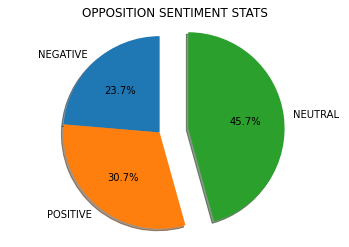

In [0]:
import matplotlib.pyplot as plt

labels =['NEGATIVE', 'POSITIVE', 'NEUTRAL']
sizes = [opp_np_pie[1][0],opp_np_pie[1][1],opp_np_pie[1][2]]
explode = [0,0,0.3]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("OPPOSITION SENTIMENT STATS")
plt.show()

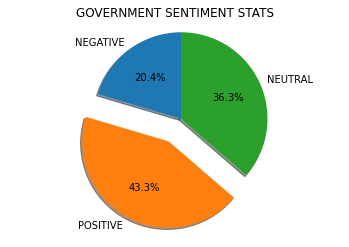

In [0]:
labels =['NEGATIVE','POSITIVE','NEUTRAL']
sizes = [gov_np_pie[1][0],gov_np_pie[1][1],gov_np_pie[1][2]]
explode = [0,0.3,0]

fig2, ax2 = plt.subplots()
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')
plt.title("GOVERNMENT SENTIMENT STATS")
plt.show()

In [0]:
print("GOVERNMENT SENTIMENT IS POSITIVE")
print("OPPOSITION SENTIMENT IS NEUTRAL")

GOVERNMENT SENTIMENT IS POSITIVE
OPPOSITION SENTIMENT IS NEUTRAL
